In [94]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing

In [2]:
import requests
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [76]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [83]:
# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

#Pack into python dictionary and convert selected fields to float
grb=dict(zip(names,data))

for label in ['T90','T90_error','fluence','fluence_error','redshift']:
    grb[label] = np.array(grb[label],dtype='float')


In [84]:
#T0=np.array(data[2],dtype=float)
ra=np.array(data[3],dtype=float)
decl=np.array(data[4],dtype=float)
pos_err=np.array(data[5],dtype=float)
T90=np.array(data[6],dtype=float)
T90_err=np.array(data[7],dtype=float)
#T90_start=np.array(data[8],dtype=float)
fluence=np.array(data[9],dtype=float)
fluence_err=np.array(data[10],dtype=float)
redshift=np.array(data[11],dtype=float)
T100=np.array(data[12],dtype=float)
GMB_located=np.array(data[13]) #,dtype=bool

Are there any structures underlying physical problems hidden in data? Histogram of T90

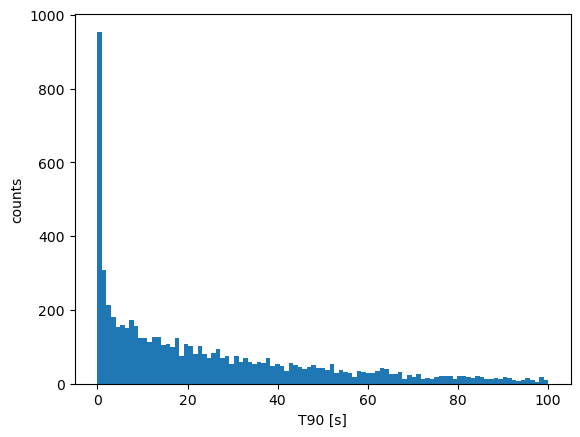

In [87]:
plt.hist(grb['T90'],bins= np.linspace(0,100,100))
plt.xlabel("T90 [s]") ; plt.ylabel("counts")
plt.show()

No information in linear scale. Let's try with log scale

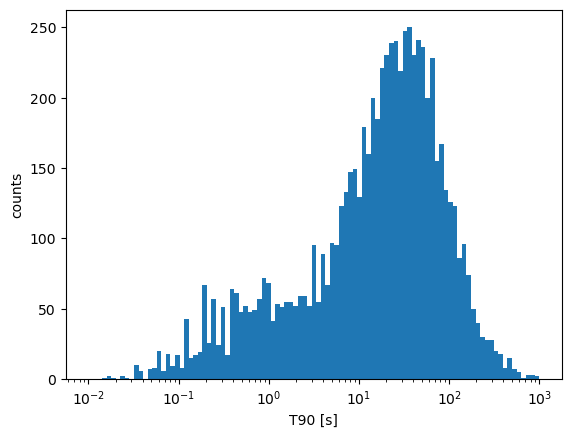

In [90]:
plt.hist(grb['T90'],bins= np.logspace(-2,3,100))
plt.semilogx() #plt.xscale("log")
plt.xlabel("T90 [s]") ; plt.ylabel("counts")
plt.show()

In log scale two distributions appear to be. But this can be due only to bin size. Let's do a fit with KDE kernel density estimation

In [92]:
# I want to fit the log of T90...
lT90 = np.log10(grb['T90'])
# Some cleaning...
lT90=lT90[~np.isnan(lT90)] 
# Reshape for scikit-learn
lT90 = lT90[:,np.newaxis]

/tmp/ipykernel_203464/1038571007.py:2: RuntimeWarning: invalid value encountered in log10
  lT90 = np.log10(grb['T90'])


In [95]:
# Fit a KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.08).fit(lT90) #fit the model to the data

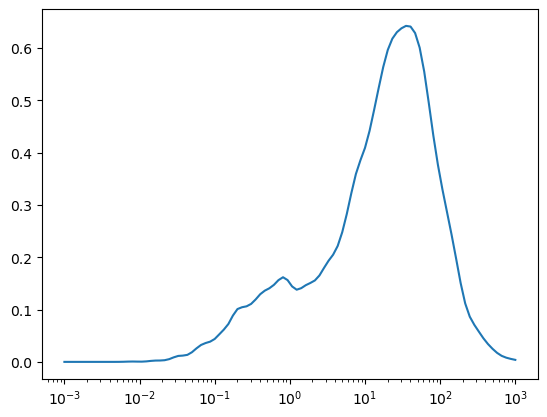

In [99]:
xgrid=np.logspace(-3,3,100)
# Rememember score_samples is the log-likelohood. Neep an exp in front
ygrid = np.exp(kde.score_samples(np.log10(xgrid)[:,np.newaxis]))

plt.plot(xgrid,ygrid)
plt.semilogx();
plt.show()

Separate the modes in an unsupervised way

In [104]:
clf = KMeans(n_clusters=2, n_init='auto') #Try 2 clusters to start with
clf.fit(lT90)

KMeans(n_clusters=2, n_init='auto')

In [110]:
centers = clf.cluster_centers_ #location of the clusters
centers = 10**np.squeeze(centers) #squeeze() function is used when we want to remove single-dimensional entries from the shape of an array
centers #in seconds

array([32.81767942,  0.87142888])

In [122]:
labels = clf.predict(lT90) #labels for each of the points. 0 for short bursts, 1 for long bursts 

In [123]:
if centers[0]>centers[1]:
    centers=centers[::-1] # Reverse array
    labels = np.array(~np.array(labels,dtype='bool'),dtype='int') # Swap 0 <--> 1

In [124]:
centers, labels

(array([ 0.87142888, 32.81767942]), array([0, 1, 1, ..., 0, 1, 0]))

In [126]:
edge = 10**( np.mean( [max(lT90[labels==0]), min(lT90[labels==1]) ])) ###????????????????????
    
print(max(lT90[labels==0]), min(lT90[labels==1]), edge)


[0.72525807] [0.72835378] 5.330966141329355


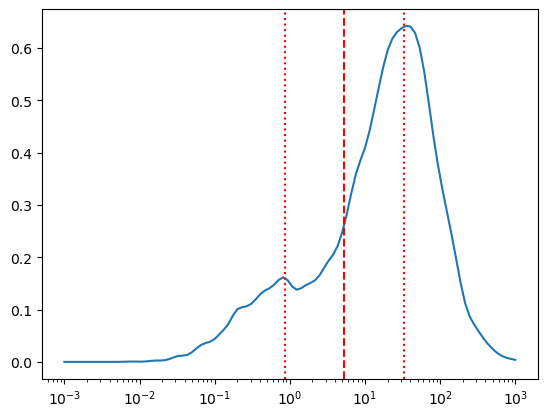

In [128]:
plt.plot(xgrid,ygrid)
plt.semilogx()
for v in centers:
    plt.axvline(v, c='red',ls='dotted')
plt.axvline(edge,c='red',ls='dashed')
plt.show()

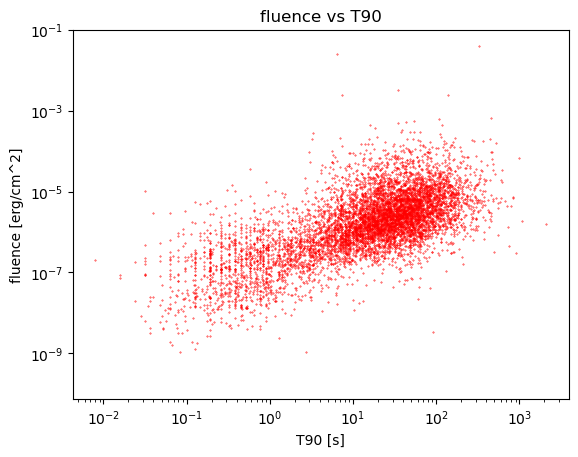

In [72]:
plt.title("fluence vs T90")
plt.scatter(T90,fluence, marker='.',s=0.5,c='r')
plt.xscale('log') ; plt.yscale('log')
plt.xlabel("T90 [s]") ; plt.ylabel("fluence [erg/cm^2]")
plt.show()

In [63]:
a=np.array([2,3,4])
b=np.log(a)
print(b)

[0.69314718 1.09861229 1.38629436]


In [60]:
T90_=T90[T90>0]
fluence_=fluence[T90>0]

print(len(T90_))
print(len(fluence_))


X = np.stack((T90_[fluence_>0], fluence_[fluence_>0]), axis=1) 
X.shape
#print(X)

7355
7355


(7237, 2)

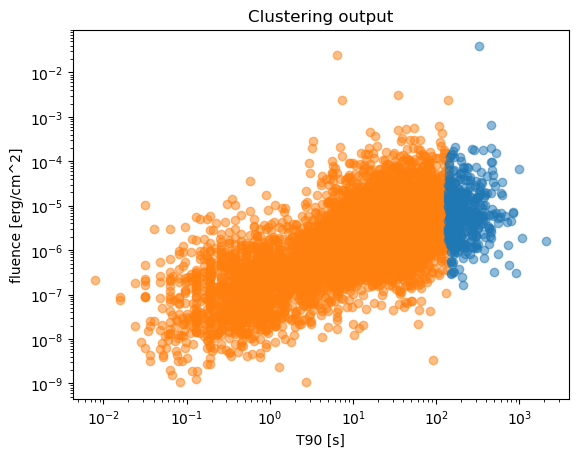

In [66]:
#K-means
from sklearn.cluster import KMeans
from sklearn import preprocessing

clf = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], color=colors[ii],alpha=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("T90 [s]") ; plt.ylabel("fluence [erg/cm^2]") 
plt.title('Clustering output');

Text(0.5, 1.0, 'Clustering output Log')

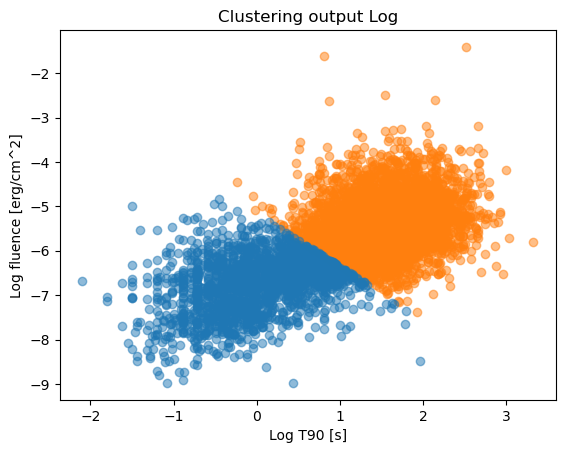

In [67]:
#K-means LOG

X = np.stack((np.log10(T90_[fluence_>0]), np.log10(fluence_[fluence_>0])), axis=1) 

from sklearn.cluster import KMeans
from sklearn import preprocessing

clf = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)

plt.xlabel("Log T90 [s]") ; plt.ylabel("Log fluence [erg/cm^2]") 
plt.title('Clustering output Log')

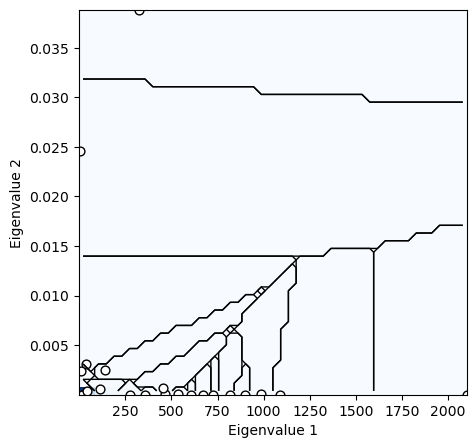

In [73]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()

In [69]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift

scaler = preprocessing.StandardScaler()
bandwidth = 0.4
#bandwidth = estimate_bandwidth(X_reduced) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(X))

MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


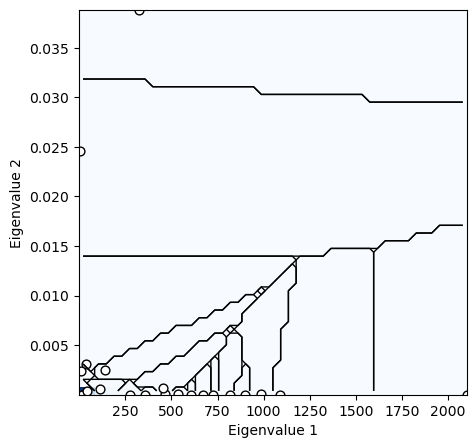

In [70]:
#labels_unique = np.unique(ms.labels_)
#n_clusters = len(labels_unique[labels_unique >= 0])
#print(labels_unique)
#print(bandwidth)
#print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()
